In [1]:
%pylab inline

import os
import gc
import fpfs
import pltutil
import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
import galsim
from fpfs.simutil import cosmoHSTGal
from fpfs.imgutil import gauss_kernel
baseDir=os.path.join(os.environ['homeWrk'],'FPFS2')

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [2]:
ngrid  =   128
scale  =   0.08
# PSF
psfFWHM=   0.4
psfInt =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
flux_scaling=   2.587
dpad   =  int(ngrid//2.4)

# Galsim galaxies
directory   =   os.path.join(os.environ['homeWrk'],\
                'COSMOS/galsim_train/COSMOS_25.2_training_sample/')
catName     =   'real_galaxy_catalog_25.2.fits'
cosmos_cat  =   galsim.COSMOSCatalog(catName,dir=directory)

# catalog
cosmo252=   cosmoHSTGal('252')
cosmo252.readHSTsample()
ss  =   cosmo252.catused[0]

psf=pyfits.getdata(os.path.join(baseDir,'sim/galaxy_basic_psf60/psf-60.fits'))
npad       =   (ngrid-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid
psfF=np.fft.fft2(np.fft.ifftshift(psfData))
gsigma=3.*2.*np.pi/64

def make_gal_image(rot,g1=0.1,g2=0.):
    gal_image=  galsim.ImageF(ngrid,ngrid,scale=scale)
    gal_image.setOrigin(0,0)

    bigfft  =   galsim.GSParams(maximum_fft_size=10240)
    # use parametric galaxies
    ang         =   rot/180.*np.pi*galsim.radians
    # each galaxy
    gal =   cosmos_cat.makeGalaxy(gal_type='parametric',\
            index=ss['index'],gsparams=bigfft)
    gal =   gal.rotate(-40./180.*np.pi*galsim.radians)
    gal =   gal.shear(g1=0.3,g2=0.)
    gal =   gal.rotate(ang)
    gal =   gal*flux_scaling
    gal =   gal.shear(g1=g1,g2=g2)
    dx  =   0.5*scale
    dy  =   0.5*scale
    gal =   gal.shift(dx,dy)
    gal =   galsim.Convolve([psfInt,gal],gsparams=bigfft)
    # draw galaxy
    gal.drawImage(gal_image,add_to_image=True)
    return gal_image.array

In [29]:
def make_plot(img1,img2,psfF,axes,cc):
    # prepare the Gaussian smoothing kernel
    gsigma=2.5*2.*np.pi/64
    gKer,grids=gauss_kernel(ngrid,ngrid,gsigma,return_grid=True)
    k2grid,k1grid=grids
    imgF1=(np.fft.fft2(img1)/psfF)*gKer
    imgF2=(np.fft.fft2(img2)/psfF)*gKer
    imgCov1=np.fft.ifft2(imgF1).real
    imgCov2=np.fft.ifft2(imgF2).real
    h=img1[dpad+1:-dpad,dpad+1:-dpad]
    ax=axes[0]
    ax.contour(h,[0.02],colors=[cc, cc],origin='lower',alpha=0.8)
    #ax.imshow(img1[dpad+1:-dpad,dpad+1:-dpad],origin='lower',cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax=axes[1]
    h=img2[dpad+1:-dpad,dpad+1:-dpad]
    ax.contour(h,[0.02],colors=[cc, cc],origin='lower',alpha=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return imgCov1[ngrid//2,ngrid//2],imgCov2[ngrid//2,ngrid//2]

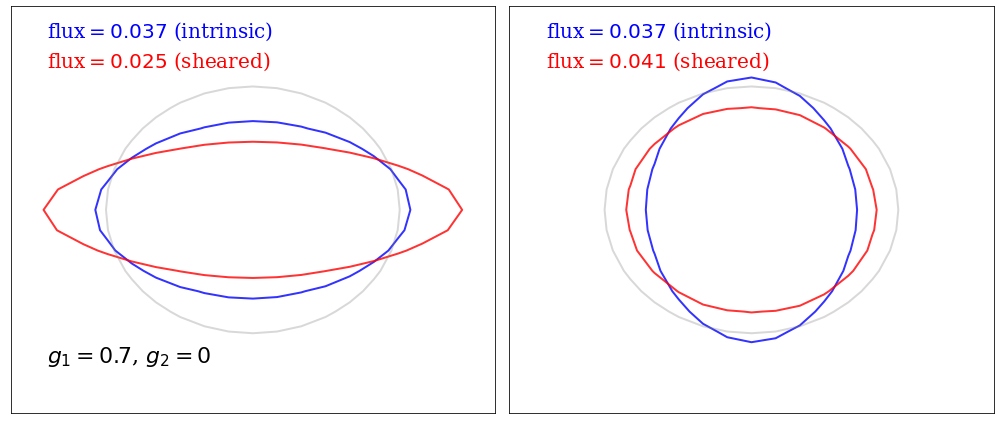

In [30]:
gc.collect()
plt.close()
fig,[ax1,ax2]=pltutil.make_figure_axes(ny=1,nx=2)

img1=make_gal_image(0.,g1=0.)
img2=make_gal_image(90.,g1=0.)
f1,f2=make_plot(img1,img2,psfF,[ax1,ax2],cc='blue')
img1=make_gal_image(0.,g1=0.7)
img2=make_gal_image(90.,g1=0.7)
s1,s2=make_plot(img1,img2,psfF,[ax1,ax2],cc='red')

gsigma=3.*2.*np.pi/64
gKer=gauss_kernel(ngrid,ngrid,gsigma,do_shift=True)
h=gKer[dpad+1:-dpad,dpad+1:-dpad]
ax1.contour(h,[0.6],colors=['gray', 'gray'],origin='lower',alpha=0.3)
ax1.text(x=2.,y=19.,s=r'flux$=%.3f$ (intrinsic)' %f1,color='blue',fontsize=20)
ax1.text(x=2.,y=17.5,s=r'flux$=%.3f$ (sheared)' %s1,color='red',fontsize=20)
ax2.contour(h,[0.6],colors=['gray', 'gray'],origin='lower',alpha=0.3)
ax2.text(x=2.,y=19.,s=r'flux$=%.3f$ (intrinsic)' %f2,color='blue',fontsize=20)
ax2.text(x=2.,y=17.5,s=r'flux$=%.3f$ (sheared)' %s2,color='red',fontsize=20)
ax1.text(x=2.,y=3.,s=r'$g_1=0.7$, $g_2=0$' %s1,color='black',fontsize=22)
plt.tight_layout()

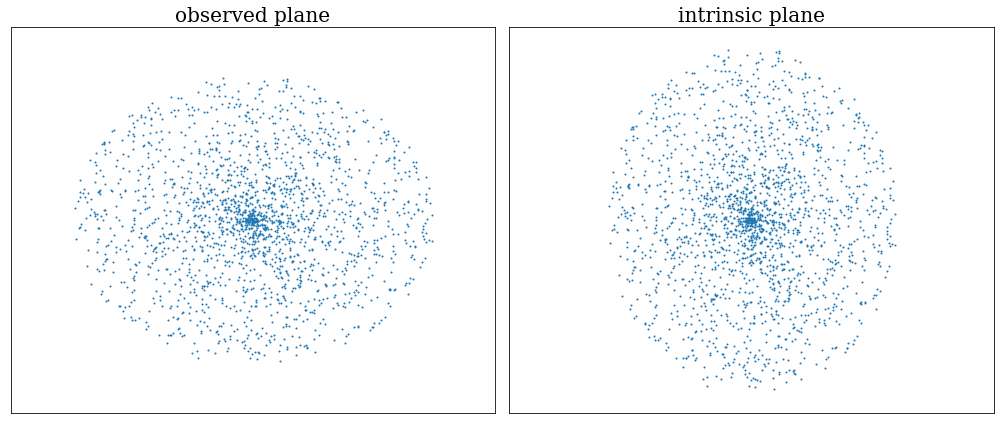

In [39]:
fig,[ax1,ax2]=pltutil.make_figure_axes(ny=1,nx=2)
g1=0.2;g2=0.
nn=2000
r=np.random.random(nn)*3.
phi=np.random.random(nn)*np.pi*2.
y=r*np.sin(phi)
x=r*np.cos(phi)
ax1.scatter(x,y,s=1.)
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title('observed plane',fontsize=20)

xi=(1-g1)*x-g2*y
yi=-g2*x+(1+g1)*y
ax2.scatter(xi,yi,s=1.)
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('intrinsic plane',fontsize=20)
plt.tight_layout()